# Tensorflow Tutorial

### Basic text classification

Outcome: Train a binary (positive or negative) text classifier to perform sentiment analysis on an IMDB dataset


In [29]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import losses

In [30]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
dataset = tf.keras.utils.get_file("aclImdb_v1", url, untar=True, cache_dir=".", cache_subdir='')
dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')
print(os.listdir(dataset_dir))

['imdb.vocab', 'imdbEr.txt', 'README', 'test', 'train']


In [32]:
# Remove unsup folder from train directory

train_dir = 'C:\\Users\\jacob\\OneDrive\Projects\\tensorflow\\src\\aclImdb\\train'
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'C:\\Users\\jacob\\OneDrive\\Projects\\tensorflow\\src\\aclImdb\\unsup'

In [12]:
batch_size = 32
seed = 42

# the text_dataset_directory reads each subfolder as a class

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='training', 
    seed=seed)

Found 75000 files belonging to 3 classes.
Using 60000 files for training.


In [ ]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Review", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

In [14]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Label 0 corresponds to neg
Label 1 corresponds to pos


In [15]:
# Create test and validation sets

raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)

raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test', 
    batch_size=batch_size)

Found 75000 files belonging to 3 classes.
Using 15000 files for validation.
Found 25000 files belonging to 2 classes.


## Prepare the dataset for training

Create a custom standardization function that strips HTML from text before feeding into the TextVectorization layer which converts tokens (individual works) into numbers that can be fed into the neural network

In [16]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

In [18]:
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [20]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

Review tf.Tensor(b"I like a lot of movies so when I started to watch this I figured it couldn't be worse then something like Crossroads. It came close. I've never been so bored and uninterested in a movie EVER. Nothing about this movie made me care about it or the people in it. The plot was hard to follow, and when I did figure out what was going on I didn't feel any better. In fact, I felt worse because I had just wasted nearly two hours of my life. The only consolation prize I have is that this movie is so unmemorable I will probably forget it by next week. I can live with that. Avoid this movie, unless you're an insomniac desperate for sleep.", shape=(), dtype=string)
Label unsup
Vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[  11,   38,    4,  164,    5,   93,   37,   50,   11,  643,    6,
         103,   10,   11, 2650,    9,  401,   26,  433,   92,  136,   38,
           1,    9,  374,  547,  198,  109,   74,   37, 1024,    3,    1,
           8,    4,

In [22]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

# configure for performance
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Create the model

- Embedding layer - takes the integer-encoded reviews and looks up an embedding vector for each word-index
- GlobalAveragePooling1D layer returns fixed-length output vector each example. Allows the model to handle variable length input

In [23]:
embedding_dim = 16

model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160016    
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
__________________________________________________

In [24]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

In [25]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
1875/1875 [==============================] - 21s 11ms/step - loss: -15.4442 - binary_accuracy: 0.1663 - val_loss: -43.8516 - val_binary_accuracy: 0.1681
Epoch 2/10
1875/1875 [==============================] - 7s 4ms/step - loss: -97.2811 - binary_accuracy: 0.1663 - val_loss: -154.0396 - val_binary_accuracy: 0.1681
Epoch 3/10
1875/1875 [==============================] - 9s 5ms/step - loss: -236.2358 - binary_accuracy: 0.1663 - val_loss: -312.7210 - val_binary_accuracy: 0.1681
Epoch 4/10
1875/1875 [==============================] - 9s 5ms/step - loss: -422.0071 - binary_accuracy: 0.1663 - val_loss: -515.1050 - val_binary_accuracy: 0.1681
Epoch 5/10
1875/1875 [==============================] - 8s 4ms/step - loss: -653.2870 - binary_accuracy: 0.1663 - val_loss: -759.9415 - val_binary_accuracy: 0.1681
Epoch 6/10
1875/1875 [==============================] - 9s 5ms/step - loss: -924.8246 - binary_accuracy: 0.1663 - val_loss: -1046.0111 - val_binary_accuracy: 0.1681
Epoch 7/10
1875/

In [27]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 1s 986us/step - loss: 2662.1294 - binary_accuracy: 0.5000
Loss:  2662.12939453125
Accuracy:  0.5


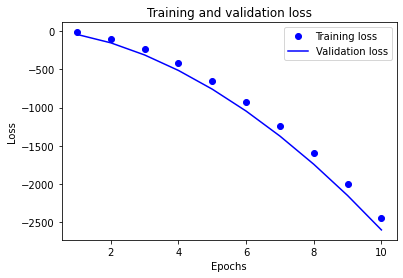

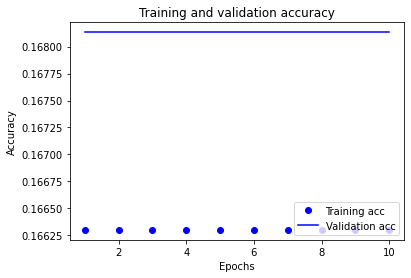

In [28]:
history_dict = history.history
history_dict.keys()

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()